# Aggregate peak analysis of differential loops

In [1]:
import cooler
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, zscore, norm
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import seaborn as sns

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
leg = ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'L5_ET', 'Amy', 
       'Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7', 
       'MSN_D1', 'MSN_D2', 'Foxp2', 'SubCtx', 
       'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]
legname = ['L2/3-IT', 'L4-IT', 'L5-IT', 'L6-IT', 'L6-IT-Car3', 'L5/6-NP', 'L6-CT', 'L6b', 'L5-ET', 'Amy-Exc', 
       'Lamp5', 'Lamp5-Lhx6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb-ChC', 'Sst', 'Chd7', 
       'MSN-D1', 'MSN-D2', 'Foxp2', 'SubCtx-Cplx', 
       'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]
leg2name = {xx:yy for xx,yy in zip(leg, legname)}


In [3]:
leg = {'exc': ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'Amy'], 
       'inh': ['Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7'], 
       'cnu': ['MSN_D1', 'MSN_D2', 'Foxp2'], 
       'sub': ['SubCtx'], 
       'glia': ['ASC', 'ODC', 'OPC'], 
       'mgc': ['MGC'], 
       'smc': ['PC'], 
       'endo': ['EC'], 
       'fibro': ['VLMC'],
      }
leg['neu'] = leg['exc'] + leg['inh'] + leg['cnu'] + leg['sub']
leg['all'] = leg['neu'] + leg['glia'] + leg['mgc'] + leg['smc'] + leg['endo'] + leg['fibro']
leg['msn'] = ['MSN_D1', 'MSN_D2']

In [4]:
group_name = 'neu'

In [5]:
ctgroup, ctname = [], []
if '_' in group_name:
    for xx in group_name.split('_'):
        ctgroup.append(leg[xx])
        ctname.append(xx.capitalize())
else:
    for xx in leg[group_name]:
        ctgroup.append([xx])
        ctname.append(leg2name[xx])
        

In [6]:
leg = pd.Index(np.concatenate(ctgroup))
legname = leg.map(leg2name)
res = 10000

In [7]:
indir = '/home/jzhou_salk_edu/sky_workdir/hba/loop_majortype/'
outdir = f'/home/jzhou_salk_edu/sky_workdir/hba/loop_majortype/diff/{group_name}/'

In [8]:
chrom_size_path = f'{indir}hg38_with_chrl.main.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)


In [9]:
loopq = pd.read_hdf(f'{outdir}loop_Q.hdf', key='data')
loopt = pd.read_hdf(f'{outdir}loop_T.hdf', key='data')
loopall = pd.read_hdf(f'{outdir}merged_loop.hdf', key='data')


In [10]:
thres1 = norm.isf(0.025)
thres2 = norm.isf(0.15)
print(thres1, thres2)


1.9599639845400545 1.0364333894937898


In [14]:
loopall[0].map(chrom_sizes)

0          248956422
1          248956422
2          248956422
3          248956422
4          248956422
             ...    
2873610     50818468
2873611     50818468
2873612     50818468
2873613     50818468
2873614     50818468
Name: 0, Length: 2873615, dtype: int64

In [11]:
selb = ((zscore(loopall['Qanova'])>thres2) & (zscore(loopall['Tanova'])>thres2))
distfilter = ((loopall[4]-loopall[1])>100000) & ((loopall[4]-loopall[1])<4950000) &  (loopall[1] >= (10*res)) & (loopall[4] < (loopall[0].map(chrom_sizes) - 10*res))
loopfilter = distfilter & selb
print(selb.sum(), loopfilter.sum())


148395 106310


In [12]:
loopall = loopall.loc[loopfilter]
loopq = loopq.loc[loopfilter]
loopt = loopt.loc[loopfilter]


In [13]:
loop_list = []
for ctlist in ctgroup:
    fc1 = loopq[ctlist].mean(axis=1) / loopq.loc[:, ~loopq.columns.isin(ctlist)].mean(axis=1)
    fc2 = loopt[ctlist].mean(axis=1) / loopt.loc[:, ~loopt.columns.isin(ctlist)].mean(axis=1)
    loop_list.append(loopall.loc[(fc1>1.2) & (fc2>1.5)])


In [14]:
[xx.shape[0] for xx in loop_list]

[23873,
 32140,
 35873,
 36295,
 23577,
 16275,
 27794,
 26613,
 11649,
 14900,
 14934,
 10081,
 8647,
 11415,
 8006,
 6544,
 7366,
 12269,
 11792,
 9530,
 5534]

In [15]:
def apa(ct):
    result = np.zeros((len(loop_list), 21, 21))
    cool = cooler.Cooler(f'{indir}/{ct}/{ct}/{ct}.Q.cool')
    for c in np.random.permutation(chrom_sizes.index[:-1]):
        Q = cool.matrix(balance=False, sparse=True).fetch(c).toarray()
        decay = np.array([np.mean(np.diag(Q, k)) for k in range(dist)])
        E = np.zeros(Q.shape)
        row, col = np.diag_indices(E.shape[0])
        E[row, col] = 1
        for k in range(1, 505):
            E[row[:-k], col[k:]] = (Q[row[:-k], col[k:]]) / decay[k]
        for j,loop in enumerate(loop_list):
            looptmp = loop.loc[(loop[0]==c), [1,4]].values // res
            for xx,yy in looptmp:
                tmp = E[(xx-10):(xx+11), (yy-10):(yy+11)]
                tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())
                result[j] += tmp
                
    for j,loop in enumerate(loop_list):
        result[j] /= loop.shape[0]
        
    return result


In [16]:
cpu = 5
dist = 505
result = np.zeros((len(leg), len(loop_list), 21, 21))
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for i,ct in enumerate(leg):
        future = executor.submit(
            apa,
            ct=ct,
        )
        futures[future] = i

    for future in as_completed(futures):
        idx = futures[future]
        result[idx] = future.result()
        print(f'{leg[idx]} finished')
        

L23_IT finished
L6_IT_Car3 finished
L6_IT finished
L5_IT finished
L4_IT finished
L6_CT finished
L56_NP finished
Amy finished
L6b finished
Lamp5 finished
Lamp5_LHX6 finished
Sncg finished
Vip finished
Pvalb_ChC finished
Pvalb finished
Sst finished
CHD7 finished
MSN_D1 finished
MSN_D2 finished
Foxp2 finished
SubCtx finished


[]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


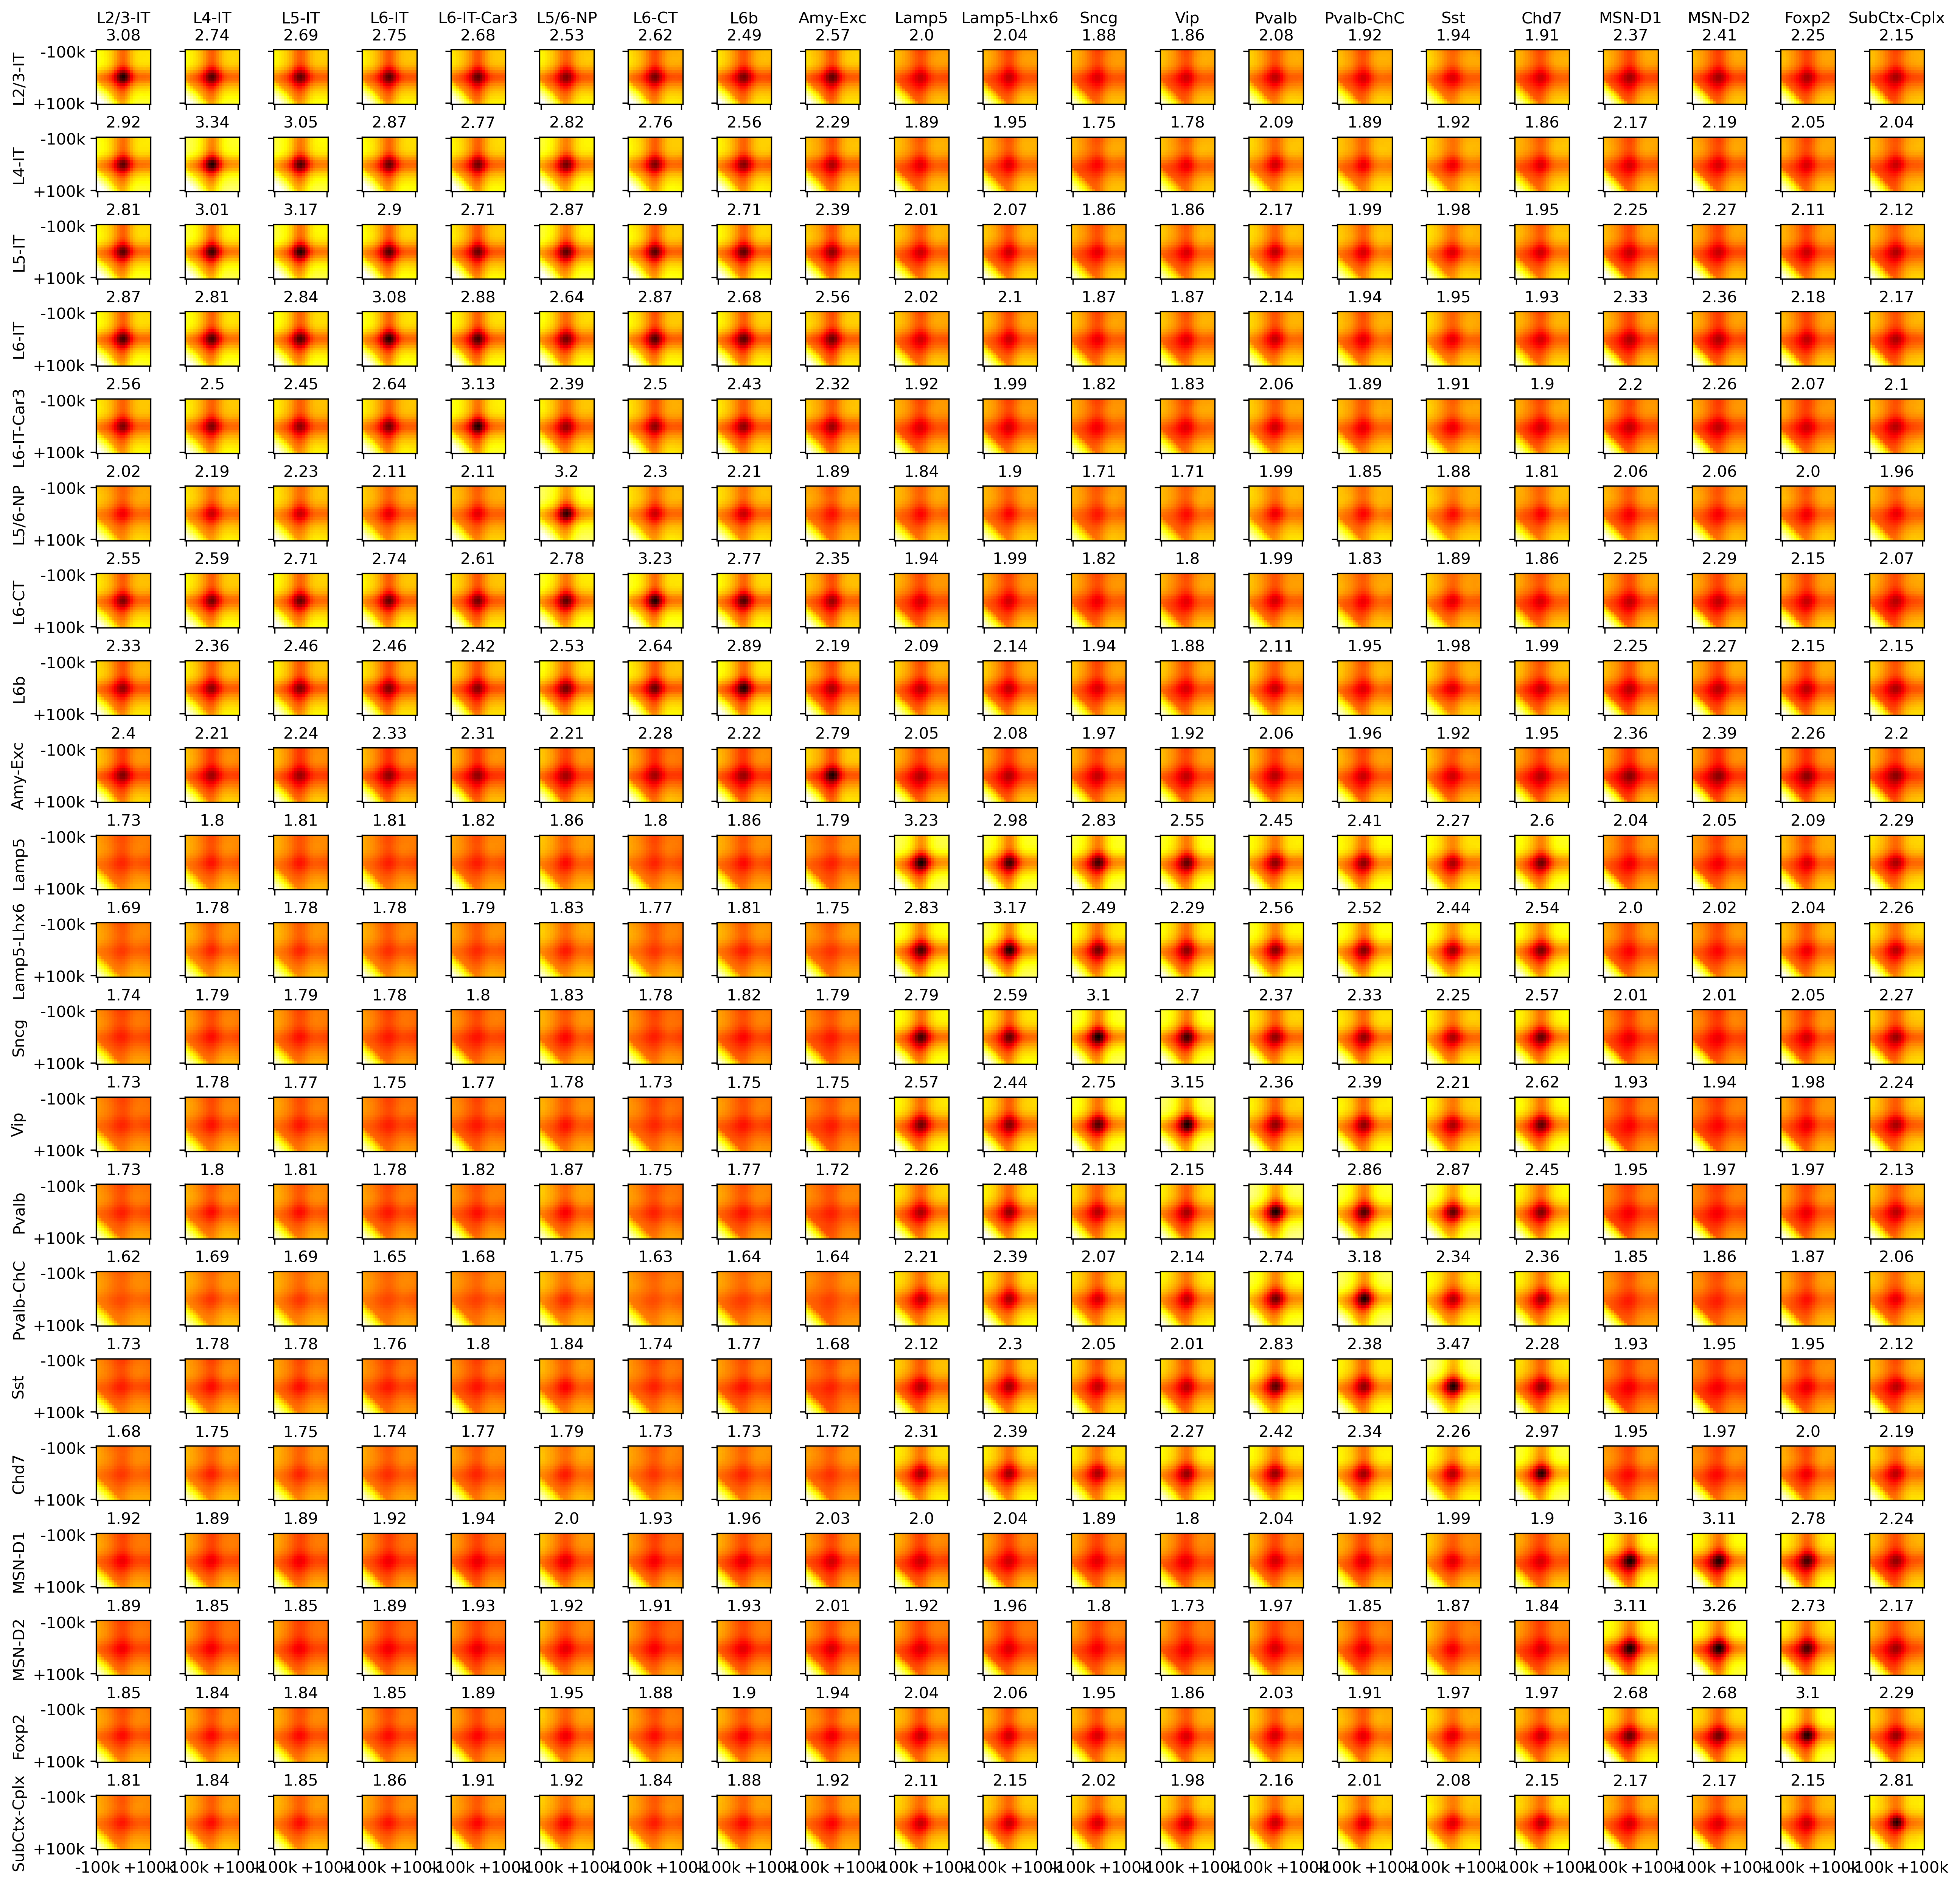

In [17]:
fig, axes = plt.subplots(len(leg), len(loop_list), figsize=(len(loop_list),len(leg)), 
                         sharex='all', sharey='all', dpi=300)
fig.subplots_adjust(wspace=0.2, hspace=0.6)
for i,ct in enumerate(leg):
    for j,loop in enumerate(loop_list):
        ax = axes[i, j]
        tmp = result[i, j]
        apa = np.around(tmp[10,10]/tmp[-5:, :5].mean(), decimals=2)
        ax.imshow(tmp, cmap='hot_r', vmax=0.8, vmin=0.2)
        if i==0:
            ax.set_title(f'{ctname[j]}\n{apa}', fontsize=10)
        else:
            ax.set_title(apa, fontsize=10)
            
for i,ct in enumerate(legname):
    axes[i,0].set_ylabel(ct)
        
ax.set_xticks([0, 20])
ax.set_xticklabels(['-100k', '+100k'])
ax.set_yticks([0, 20])
ax.set_yticklabels(['-100k', '+100k'])

# plt.tight_layout()
# plt.savefig(f'{indir}diff/plot/{group_name}_diffloop_apa.pdf', transparent=True)


In [18]:
np.savez(f'{outdir}apa.npz', apa=result, leg=leg)
